In [39]:

#Import the liberaries 
import pandas as pd
import numpy as np
# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
import statsmodels.api as sm 
from sklearn.metrics import roc_curve,confusion_matrix , accuracy_score, classification_report , roc_auc_score, f1_score,precision_score, recall_score
from plot_metric.functions import BinaryClassification
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.preprocessing import PowerTransformer

pd.options.display.max_rows=200

In [40]:
def Find_Optimal_Cutoff(target, predicted):    
    '''Find data-driven cut-off for classification
    
    Cut-off is determied using Youden's index defined as sensitivity + specificity - 1.
    
    Parameters
    ----------
    
    y_true : array, shape = [n_samples]
        True binary labels.
        
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class,
        confidence values, or non-thresholded measure of decisions (as returned by
        “decision_function” on some classifiers).
        
    References
    ----------
    
    Ewald, B. (2006). Post hoc choice of cut points introduced bias to diagnostic research.
    Journal of clinical epidemiology, 59(8), 798-801.
    
    Steyerberg, E.W., Van Calster, B., & Pencina, M.J. (2011). Performance measures for
    prediction models and markers: evaluation of predictions and classifications.
    Revista Espanola de Cardiologia (English Edition), 64(9), 788-794.
    
    Jiménez-Valverde, A., & Lobo, J.M. (2007). Threshold criteria for conversion of probability
    of species presence to either–or presence–absence. Acta oecologica, 31(3), 361-369.
    '''
    
    
    fpr, tpr, thresholds = roc_curve(target, predicted)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

In [41]:
data_final=pd.read_hdf('df_subjects_homelessnes.h5','df_subjects_homelessnes')

In [42]:
day=360
data_final=data_final[data_final['date_difference']>=timedelta(day)]

In [43]:
data_final['homeless'].unique()

array([0, 1])

In [45]:


data_final=data_final.join(pd.get_dummies(data_final['sex'], prefix='sex'))
data_final['age_categorical']=data_final['age'].map(lambda x: '18-29' if ((x>=18) and (x<30)) else ('30-39' if ((x>=30) and (x<40)) else ('40-49' if ((x>=40) and (x<50)) else ('50-59' if ((x>=50) and (x<60)) else ('60+' if x>=60 else '')))) )
data_final=data_final.join(pd.get_dummies(data_final['age_categorical'], prefix='age'))

data_final[['age', 'quintmat', 'quintsoc']]=data_final[['age', 'quintmat', 'quintsoc']].apply(lambda x: x.astype(int))


In [46]:
data_final.to_hdf('ARC_Homelessness_training/data/data_final_homlessness.h5', 'data_final_homlessness')

In [23]:
# data_final=data_final.join(pd.get_dummies(data_final['sex'],prefix='sex'))
feature_list_for_training=[ 
       'sex_M',
       'age',
   
       'substance', 
       'mood', 
       'anxiety', 
       'psychotic', 
       'cognitive', 
       'otherpsych',
       'selfharm', 
    
       'visit_emr_MH_non_elect', 
       'visit_emr_NonMH',
       'visit_emr_visit', 
       
       'visit_hosp_visit',
       'visit_hospitalized_MH', 
       'visit_hospitalized_NonMH', 
    
       'visit_family_gp', 
       'visit_im',
       'visit_neurology', 
       'visit_other', 
       'visit_pharmacy', 
       'visit_psychiatry',
    
       'EX_CHF', 
       'EX_Arrhy', 
       'EX_VD', 
       'EX_PCD', 
       'EX_PVD', 'EX_HPTN_UC',
       'EX_HPTN_C', 'EX_Para', 'Ex_OthND', 'Ex_COPD', 'Ex_Diab_UC',
       'Ex_Diab_C', 'Ex_Hptothy', 'Ex_RF', 'Ex_LD', 'Ex_PUD_NB', 'Ex_HIV',
       'Ex_Lymp', 'Ex_METS', 'Ex_Tumor', 'Ex_Rheum_A', 'Ex_Coag', 'Ex_Obesity',
       'Ex_WL', 'Ex_Fluid', 'Ex_BLA', 'Ex_DA', 'Ex_Alcohol', 'Ex_Drug',
       'Ex_Psycho', 'Ex_Dep', 'Ex_Stroke', 'Ex_Dyslipid', 'Ex_Sleep', 'Ex_IHD',
       'EX_Fall', 'EX_Urinary', 'EX_Visual', 'EX_Hearing', 'EX_Tobacco',
       'EX_Delirium', 'Ex_MS', 'EX_parkinsons', 

]

In [25]:
# separate the features for training 
X=data_final[feature_list_for_training]
# separate the labels for the training 
y=data_final['homeless']

# add the constant to the x features
X=sm.add_constant(X)
# split the dataset into train and tes set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

######################################

print("### Classes percentage in the training as there are imbalanceness:") 
print(y_train.value_counts()*100/len(y_train))

# fit the model
log_reg=sm.Logit(y_train,X_train ).fit()

# after fitting the model, we need to test the model on the x_test (y_hat are the predicted probabilities)
yhat = log_reg.predict(X_test)
# recieve the labels from the y_hat for the classification

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


### Classes percentage in the training as there are imbalanceness:
0    98.400647
1     1.599353
Name: homeless, dtype: float64
Optimization terminated successfully.
         Current function value: 0.067306
         Iterations 13


In [26]:
# Find optimal probability threshold by using the yhat as a continuous measure
threshold = Find_Optimal_Cutoff(y_test, yhat)
print(threshold)

# Find prediction to the dataframe applying threshold :
# choose the cutoff so that the outcome is more balanced, using either the youden index 

prediction = pd.Series(yhat).map(lambda x: 1 if x > threshold else 0)

0.023438665657485713


Confusion Matrix : 
 [[20629  2594]
 [  109   303]]
Test accuracy =  0.8856357097524857
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     23223
           1       0.10      0.74      0.18       412

    accuracy                           0.89     23635
   macro avg       0.55      0.81      0.56     23635
weighted avg       0.98      0.89      0.93     23635

F1 Score: 0.18313689936536717
AUC: 0.81%


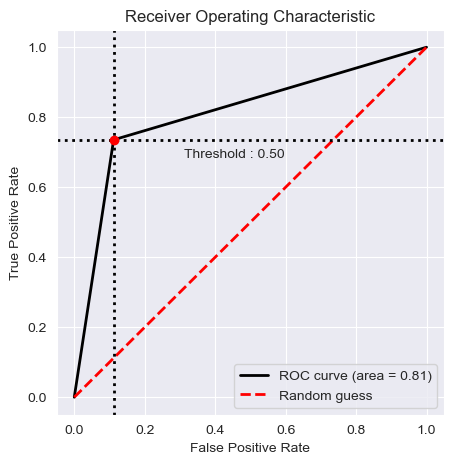

In [27]:
# confusion matrix for the test dataset
cm = confusion_matrix(y_test, prediction)
print ("Confusion Matrix : \n", cm)

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

print(classification_report(y_test, prediction))

print("F1 Score: {}".format(f1_score(y_test, prediction)))

roc_auc = roc_auc_score(y_test, prediction)
print('AUC: %.2f' % roc_auc + "%")



# Visualisation with plot_metric
bc = BinaryClassification(y_test, prediction, labels = ["Class 1", "Class 2"])

# Figures
plt.figure(figsize = (5,5))
bc.plot_roc_curve()
plt.show()

# Pre_processing (Balncing the classes +normalization )

In [28]:
# only balnce the classes with out normalization 

X=data_final[feature_list_for_training]

scaler_PT = PowerTransformer() 

X = pd.DataFrame(scaler_PT.fit_transform(X), columns=X.columns)
X=sm.add_constant(X)
#split to test and training 
# x_train : features for the training the model
# x_test :features for testing the model 

# y_train: the labels for the training the model
# y_test: the labels for the testing  the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)


#only oversample for the trian sets


over_sampler = RandomOverSampler(random_state=42)

X_train, y_train = over_sampler.fit_resample(X_train, y_train)

######################################

print("### Classes percentage in the training as there are no longer any imbalanceness:") 
print(y_train.value_counts()*100/len(y_train))


# fit the model
log_reg=sm.Logit(y_train,X_train ).fit()

# after fitting the model, we need to test the model on the x_test (y_hat are the predicted probabilities)
yhat = log_reg.predict(X_test)
# recieve the labels from the y_hat for the classification


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


### Classes percentage in the training as there are no longer any imbalanceness:
0    50.0
1    50.0
Name: homeless, dtype: float64
Optimization terminated successfully.
         Current function value: 0.315026
         Iterations 7


In [29]:
# Find optimal probability threshold by using the yhat as a continuous measure
threshold = Find_Optimal_Cutoff(y_test, yhat)
print(threshold)
# Find prediction to the dataframe applying threshold :
# choose the cutoff so that the outcome is more balanced, using either the youden index 
prediction = pd.Series(yhat).map(lambda x: 1 if x > threshold else 0)

0.4165048427345928


Confusion Matrix : 
 [[19651  3572]
 [   39   373]]
Test accuracy =  0.8472181087370425
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     23223
           1       0.09      0.91      0.17       412

    accuracy                           0.85     23635
   macro avg       0.55      0.88      0.54     23635
weighted avg       0.98      0.85      0.90     23635

F1 Score: 0.17121872848290107
AUC: 0.88%


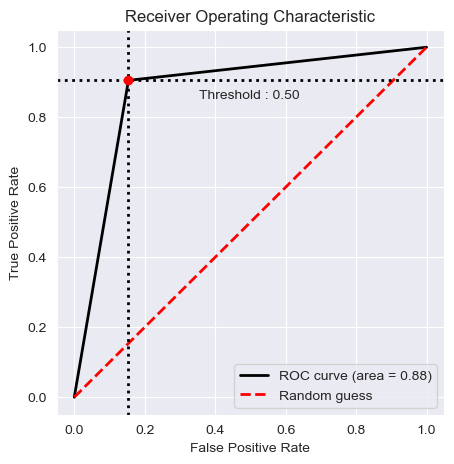

In [30]:
# confusion matrix
cm = confusion_matrix(y_test, prediction)
print ("Confusion Matrix : \n", cm)

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

print(classification_report(y_test, prediction))

print("F1 Score: {}".format(f1_score(y_test, prediction)))

roc_auc = roc_auc_score(y_test, prediction)
print('AUC: %.2f' % roc_auc + "%")

# Visualisation with plot_metric
bc = BinaryClassification(y_test, prediction, labels = ["Class 1", "Class 2"])

# Figures
plt.figure(figsize = (5,5))
bc.plot_roc_curve()
plt.show()